In [23]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.image import pad_to_bounding_box
from tensorflow.image import central_crop
from tensorflow.image import resize
from PIL import Image

In [24]:
# 이미지 불러오기
target_size = (64, 64)

images = []
for i in range(1, 4001):
    try:
        img = load_img(f"train/{i}.png", target_size=target_size)  # 이미지 크기 조정
        image_arr = img_to_array(img)
        images.append(image_arr)
    except FileNotFoundError:
        print(f"파일 {i}.png를 찾을 수 없습니다.")

In [25]:
# 이후에 np.array 변환과 정규화 수행
images = np.array(images) / 255.0

In [26]:
images.shape

(4000, 64, 64, 3)

In [5]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import tensorflow_addons as tfa
import math

In [28]:
import tensorflow as tf
import math
import tensorflow_addons as tfa

augmented_images = []

for image in images:
    # 1.Original Image
    augmented_images.append(image)

#     # 2.Random Rotation within ±30 degrees
#     rotation_degree = tf.random.uniform([], minval=-30, maxval=30, dtype=tf.float32)
#     rotation_radian = rotation_degree * math.pi / 180
#     rotated_tensor = tfa.image.rotate(image, rotation_radian)
#     augmented_images.append(rotated_tensor.numpy())

    # 3.Random Brightness Adjustment
    brightness_tensor = tf.image.random_brightness(image, max_delta=0.5)
    augmented_images.append(brightness_tensor.numpy())

    # 4.Random Contrast Adjustment
    contrast_tensor = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    augmented_images.append(contrast_tensor.numpy())

    # 5.Random Saturation Adjustment
    saturation_tensor = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    augmented_images.append(saturation_tensor.numpy())

    # 6.Random Zoom
    zoom_tensor = tf.keras.preprocessing.image.random_zoom(image, zoom_range=(0.8, 1.2), row_axis=0, col_axis=1, channel_axis=2)
    augmented_images.append(zoom_tensor)

#     # 7.Random Shear
#     shear_tensor = tf.keras.preprocessing.image.random_shear(image, intensity=0.2, row_axis=0, col_axis=1, channel_axis=2)
#     augmented_images.append(shear_tensor)

#     # 8.Random Width Shift
#     width_shift_tensor = tf.keras.preprocessing.image.random_shift(image, wrg=0.2, hrg=0, row_axis=0, col_axis=1, channel_axis=2)
#     augmented_images.append(width_shift_tensor)

#     # 9.Random Height Shift
#     height_shift_tensor = tf.keras.preprocessing.image.random_shift(image, wrg=0, hrg=0.2, row_axis=0, col_axis=1, channel_axis=2)
#     augmented_images.append(height_shift_tensor)

# Now, augmented_images list contains 5 original transformations plus 4 new transformations for each image.

    

In [29]:
len(augmented_images)

20000

In [31]:
# 레이블준비
# 각 레이블에 대해 400개의 이미지가 있다고 가정하고 레이블 생성
# 원본 라벨링 데이터
# 0부터 2까지의 숫자를 각각 2000번씩 반복
original_labels = np.repeat(np.arange(0, 2), 2000)
labels = np.repeat(original_labels, 5)

In [32]:
len(labels)

20000

In [33]:
# 이미지와 레이블을 섞어서 훈련 데이터와 검증 데이터로 분할
train_x, val_x, train_y, val_y = train_test_split(
    augmented_images, labels, test_size=0.2, shuffle=True, random_state=42)

In [34]:
# 타겟 데이터 정규화
num_classes=2

train_y = to_categorical(train_y, num_classes=num_classes)  # 원-핫 인코딩
val_y = to_categorical(val_y, num_classes=num_classes)

In [35]:
import numpy as np

train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)

print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("val_x shape:", val_x.shape)
print("val_y shape:", val_y.shape)

train_x shape: (16000, 64, 64, 3)
train_y shape: (16000, 2)
val_x shape: (4000, 64, 64, 3)
val_y shape: (4000, 2)


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam



In [37]:
num_classes = 2
model = Sequential()

# 첫 번째 컨볼루션 블록
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# 두 번째 컨볼루션 블록
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# 세 번째 컨볼루션 블록
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# 플래튼 및 완전 연결 레이어
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

# Early Stopping, Model Checkpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('stare_model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)



In [40]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(
    train_x, 
    train_y, 
    validation_data=(val_x, val_y),
    epochs=100,
    batch_size=64,  # You can change the number 32 to whatever batch size you prefer
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
250/250 [==============================] - 42s 165ms/step - loss: 0.8781 - accuracy: 0.5626 - val_loss: 0.7131 - val_accuracy: 0.5010
Epoch 2/100


C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 43s 171ms/step - loss: 0.6708 - accuracy: 0.6392 - val_loss: 0.5981 - val_accuracy: 0.7470
Epoch 3/100
250/250 [==============================] - 41s 166ms/step - loss: 0.6131 - accuracy: 0.6810 - val_loss: 0.5504 - val_accuracy: 0.7548
Epoch 4/100
250/250 [==============================] - 40s 161ms/step - loss: 0.5728 - accuracy: 0.7110 - val_loss: 0.5282 - val_accuracy: 0.7418
Epoch 5/100
250/250 [==============================] - 40s 161ms/step - loss: 0.5457 - accuracy: 0.7324 - val_loss: 0.5086 - val_accuracy: 0.7505
Epoch 6/100
250/250 [==============================] - 40s 161ms/step - loss: 0.5218 - accuracy: 0.7451 - val_loss: 0.4798 - val_accuracy: 0.7703
Epoch 7/100
250/250 [==============================] - 40s 161ms/step - loss: 0.4985 - accuracy: 0.7608 - val_loss: 0.4684 - val_accuracy: 0.7750
Epoch 8/100
250/250 [==============================] - 42s 168ms/step - loss: 0.4811 - accuracy: 0.7728 - val_loss: 0.4543 - val_accurac

Epoch 58/100
250/250 [==============================] - 39s 155ms/step - loss: 0.1800 - accuracy: 0.9348 - val_loss: 0.1882 - val_accuracy: 0.9247
Epoch 59/100
250/250 [==============================] - 39s 156ms/step - loss: 0.1771 - accuracy: 0.9353 - val_loss: 0.2023 - val_accuracy: 0.9185
Epoch 60/100
250/250 [==============================] - 41s 164ms/step - loss: 0.1775 - accuracy: 0.9330 - val_loss: 0.1873 - val_accuracy: 0.9260
Epoch 61/100
250/250 [==============================] - 39s 154ms/step - loss: 0.1751 - accuracy: 0.9360 - val_loss: 0.1743 - val_accuracy: 0.9323
Epoch 62/100
250/250 [==============================] - 39s 155ms/step - loss: 0.1735 - accuracy: 0.9364 - val_loss: 0.1984 - val_accuracy: 0.9222
Epoch 63/100
250/250 [==============================] - 39s 156ms/step - loss: 0.1725 - accuracy: 0.9356 - val_loss: 0.1915 - val_accuracy: 0.9243
Epoch 64/100
250/250 [==============================] - 38s 153ms/step - loss: 0.1659 - accuracy: 0.9394 - val_loss: 0

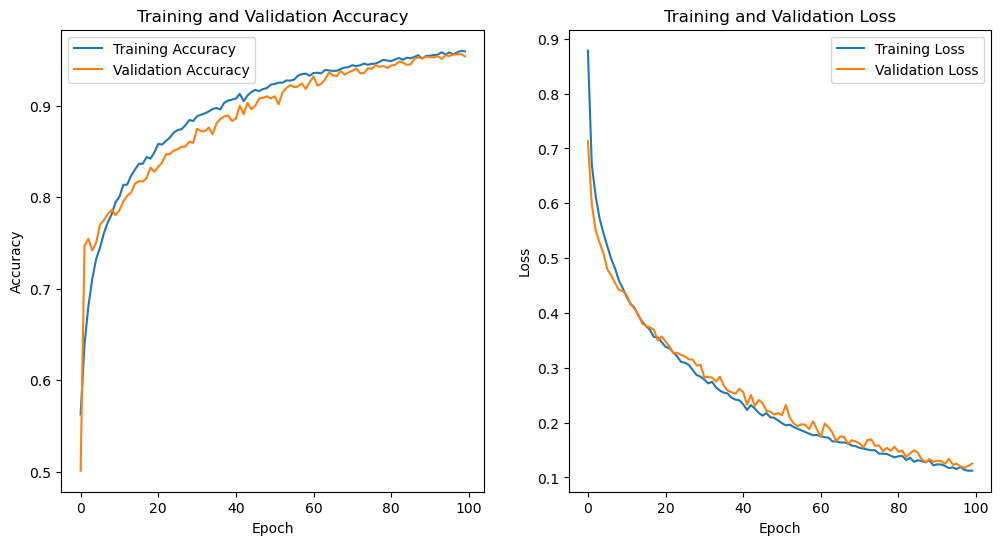

In [41]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 그래프
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
# 모델 평가
loss, accuracy = model.evaluate(val_x, val_y)
print(f"Loss: {loss}, Accuracy: {accuracy}")



125/125 [==============================] - 2s 16ms/step - loss: 0.1256 - accuracy: 0.9542
Loss: 0.12555423378944397, Accuracy: 0.9542499780654907


In [43]:
pred_y=model.predict(val_x)
predicted_classes = np.argmax(pred_y, axis=1)
predicted_classes

125/125 [==============================] - 2s 16ms/step


array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [45]:
model = tf.keras.models.load_model('stare_model.h5')

In [20]:
pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [46]:
import tkinter as tk
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf
import time
import os

In [47]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.image import pad_to_bounding_box
from tensorflow.image import central_crop
from tensorflow.image import resize
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tkinter as tk
from PIL import Image, ImageTk
import cv2
import numpy as np
import tensorflow as tf
import time
import os
import json
import time
from collections import Counter
from datetime import datetime

OSError: No file or directory found at emotion_model.h5

In [ ]:
# 웹캠을 활용한 감정분석
class FaceRecognitionApp:
    def init(self, window, window_title, model):
        self.emotions_df= pd.DataFrame(columns=['Timestamp','Predicted_Emotion' ])
        self.window = window
        self.window.title(window_title)
        self.model = model
        self.video_source = 0
        self.vid = cv2.VideoCapture(self.video_source)
        
        
        if not self.vid.isOpened():
            raise ValueError("Unable to open video source", self.video_source)
        self.canvas = tk.Label(window, width=640, height=480)
        self.canvas.pack()
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.window.bind("<space>", self.on_close)
        self.update()
        self.window.mainloop()
        
      
    def predict_emotion(self, face_img):
        try:
            resized_img = cv2.resize(face_img, (64, 64))
            filename = f"image_{int(time.time())}.png"
            filepath = f"images/{filename}"
            cv2.imwrite(filepath, resized_img)
            img = load_img(filepath)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            predictions = self.model.predict(img_array)                    
            class_index = np.argmax(predictions[0])
            emotions = ["Surprise", "Sad", "Happy", "Angry", "Neutral", "Confident"]
            
            predicted_emotion = emotions[class_index]
            current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                      
            new_data = {'Timestamp': current_time, 'Predicted_Emotion': predicted_emotion}
            self.emotions_df.loc[len(self.emotions_df)] = [current_time, predicted_emotion]
            print(predicted_emotion)
            return predicted_emotion

        except Exception as e:
            print(f"Error in predict_emotion: {e}")
            return "Error"
        
    def on_close(self, event=None):  # 이벤트 핸들러에 맞게 인자 수정
        print("Closing application and saving data...")
        self.save_emotion_data()   
        self.vid.release()  # 카메라 해제
        self.window.destroy()  # 윈도우 종료       

    # 감정의 빈도 계산
    def get_emotion_frequencies(self):
        emotion_frequencies = Counter(emotion for emotion, _ in self.emotion_scores)
        return emotion_frequencies
    
    def update(self):
        ret, frame = self.vid.read()
        if ret:
            self.display_frame(frame)
            self.window.after(1, self.update)
        
    def print_emotion_data(self):
        print(self.emotions_df)      
        
    def display_frame(self, frame):
        try:
            frame = cv2.resize(frame, (640, 480))
            faces = self.face_cascade.detectMultiScale(frame, 1.1, 4)
            for (x, y, w, h) in faces:
                # 얼굴 크기가 충분히 큰지 확인
                if w >= 100 and h >= 100:
                    face_img = frame[y:y+h, x:x+w]
                    emotion = self.predict_emotion(face_img)
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
                else:
                    print("Detected face is too small")
            
            cv2image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
            self.img = Image.fromarray(cv2image)
            self.imgtk = ImageTk.PhotoImage(image=self.img)
            self.canvas.imgtk = self.imgtk
            self.canvas.configure(image=self.imgtk)
        except Exception as e:
            print(f"display_frame에서 오류 발생: {e}")

            

    def save_emotion_data(self):
        self.emotions_df.to_csv("emotion_data.csv", index=False)
        print("Emotion data saved to 'emotion_data.csv'.")   

# 메인 부분
if __name__ == '__main__':
    root = tk.Tk()
    model = keras.models.load_model('emotion_model.h5')
    app =  FaceRecognitionApp(root, "Face Recognition", model)